# Transformers Time Series Augmentation

In [ ]:
# Data preprocessing
from scipy.io import arff
import pandas as pd
import numpy as np

# Data augmentation
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
from soft_dtw import SoftDTW

# PCA
from sklearn.decomposition import PCA

# Classification and plotting
import AutomatingClassification as automator
import matplotlib.pyplot as plt

## Read in and prepare the data

In [ ]:
def readArffToDf(fileName):
    data = arff.loadarff(fileName)
    return pd.DataFrame(data[0])

In [ ]:
train = readArffToDf('Earthquakes_TRAIN.arff')
test = readArffToDf('Earthquakes_TEST.arff')

In [ ]:
train['target'] = train['target'].astype(int)
test['target'] = test['target'].astype(int)

### Leaving the classes together for time series classification

In [ ]:
trainX = train.drop(columns=['target'])
trainY = train['target']

testX = test.drop(columns=['target'])
testY = test['target']

### Separating out our classes for data augmentation

In [ ]:
trainLabel1 = train [ train['target'] == 1 ]
trainLabel0 = train [ train['target'] == 0 ]

In [ ]:
trainLabel1X = trainLabel1.drop(columns=['target'])
trainLabel1Y = trainLabel1['target']

trainLabel0X = trainLabel0.drop(columns=['target'])
trainLabel0Y = trainLabel0['target']

## Create transformers model

In [ ]:
def generateSample(df, dimsToAdd=1):
    """
    Function generates a sample from a given dataframe and converts it to a tensor.
    """
    lastDfIndex = len(df) - 1
    chosenIndex = random.randint(0, lastDfIndex)
    data = df.iloc[chosenIndex].values
    
    if dimsToAdd == 1:
        data = [data]
    elif dimsToAdd == 2:
        data = [[data]]
    
    return torch.Tensor(data)

In [ ]:
class DataAugmenter:

  def __init__(self, label):
    """
    The label should equal either 1 or 0. It determines which dataset we grab from.
    """
    if label == 1:
      self.source = generateSample(trainLabel1X, 2)
      self.target = generateSample(trainLabel1X, 2)
    elif label == 0:
      self.source = generateSample(trainLabel0X, 2)
      self.target = generateSample(trainLabel0X, 2)
    else:
      raise Exception('You should enter either 1 or 0 in for the label parameter.')

    # Create the remaining objects that we need for training the model.
    self.model = nn.Transformer(d_model=512)


  def trainModel(self, lr, epochs, lossFunctionType, verbose):
    """
    This model uses the same source and target dataset the entire time,
    rather than switching.

    The lossFunctionType parameter determines the type of the loss function.
    It should equal either 'MSE' or 'SoftDTW'.
    """
    if lossFunctionType == 'MSE':
      lossFunction = nn.MSELoss()
    elif lossFunctionType == 'SoftDTW':
      lossFunction = SoftDTW(gamma=1.0, normalize=True)
    else:
      raise Exception('The incorrect value was entered.')

    optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)

    for i in range(epochs):

      # Compute prediction and loss
      pred = self.model(self.source, self.target)
      loss = lossFunction(pred, self.target)
      
      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Optionally report on the results.
      lossFloat = loss.item()
      if verbose:
        s = "Loss for iteration {}: {:.3f}".format(i, lossFloat)
        print(s)

  def generateAugmentedData(self):
    # Turn off gradient calculation.
    self.model.eval()

    # Generate and return the output.
    with torch.no_grad():
      output = self.model(self.source, self.target)
      self.augmented = output.detach().numpy()[0][0]

  def plotData(self, fileName=None):
    """
    Function will save the file if fileName is not None.
    """

    figure, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15,7))

    # Source plot
    source = self.source.detach().numpy()[0][0]
    ax1.plot(source)
    ax1.set_title('Source data')

    # Target plot
    target = self.target.detach().numpy()[0][0]
    ax2.plot(target)
    ax2.set_title('Target data')

    # Augmented plot
    augmented = self.augmented
    ax3.plot(augmented)
    ax3.set_title('Augmented data')

    if fileName is not None:
      plt.savefig(fileName)

## Generate some sample augmented data for both classes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  


Loss for iteration 0: 990.236
Loss for iteration 1: 162.606
Loss for iteration 2: 71.812
Loss for iteration 3: 26.556
Loss for iteration 4: 38.586
Loss for iteration 5: 46.037
Loss for iteration 6: 48.017
Loss for iteration 7: 71.224
Loss for iteration 8: 22.585
Loss for iteration 9: 64.952


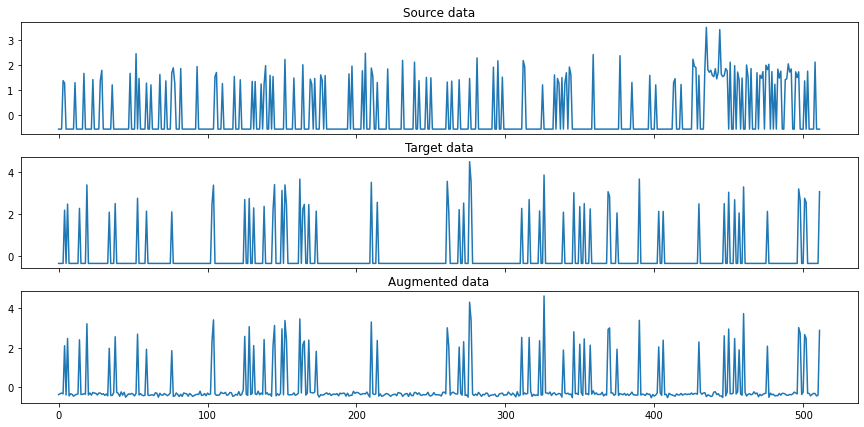

In [ ]:
augmenter = DataAugmenter(label=1)
augmenter.trainModel(0.01, 10, 'SoftDTW', True)
augmenter.generateAugmentedData()
augmenter.plotData(fileName='Class 1 Augmented Transformer.png')

Loss for iteration 0: 1034.544
Loss for iteration 1: 101.170
Loss for iteration 2: 72.665
Loss for iteration 3: 48.345
Loss for iteration 4: 60.398
Loss for iteration 5: 39.547
Loss for iteration 6: 30.310
Loss for iteration 7: 59.041
Loss for iteration 8: 70.180
Loss for iteration 9: 56.981


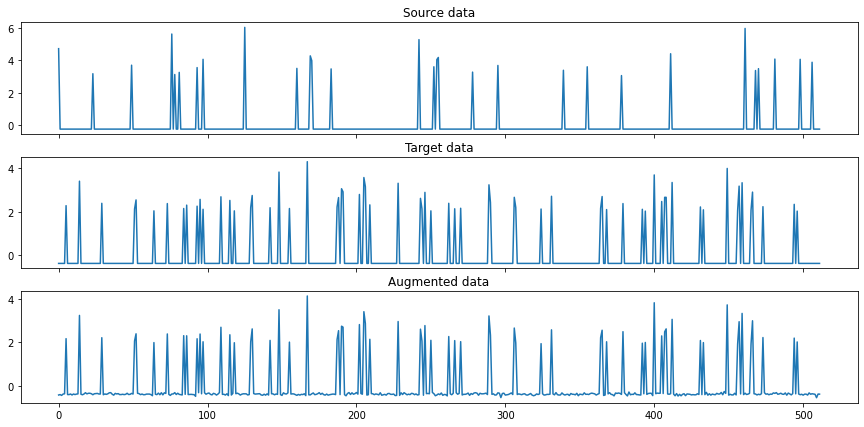

In [ ]:
augmenter = DataAugmenter(label=0)
augmenter.trainModel(0.01, 10, 'SoftDTW', True)
augmenter.generateAugmentedData()
augmenter.plotData('Class 0 Augmented Transformer.png')

## PCA

In [ ]:
def generateAugmentedDataset(nSamples, label):
  """
  Function generates large numbers of augmented datasets and returns them in
  a dataframe. The label should be either 1 or 0.
  """
  nestedListResults = []

  for i in range(nSamples):
    augmenter = DataAugmenter(label=label)
    augmenter.trainModel(0.01, 10, 'SoftDTW', False)
    augmenter.generateAugmentedData()
    augmentedList = list(augmenter.augmented)
    nestedListResults.append(augmentedList)

    report = '{:.2%}'.format(i/nSamples)
    print(report, end=', ')

  return np.array(nestedListResults)

In [ ]:
def getPCA(dataset):
  pca = PCA(n_components=2)
  components = pca.fit_transform(dataset)
  c1 = components[:, 0]
  c2 = components[:, 1]
  print('Explained variance ratio: {}'.format(pca.explained_variance_ratio_))
  return c1, c2

In [ ]:
def plotPCA(componentsList, colorList, labelList, fileName=None):
  """
  The componentsList should contain a list of tuples. The tuples will contain
  (component1, component2).

  If the fileName parameter is filled, it will save the file. Otherwise,
  it will not be saved.
  """
  plt.figure(figsize=(15,8))
  plt.title('PCA Scatterplot')
  plt.xlabel('PC1')
  plt.ylabel('PC2')

  for i in range(len(componentsList)):
    compTuple = componentsList[i]
    c1 = compTuple[0]
    c2 = compTuple[1]
    color = colorList[i]
    label = labelList[i]
    plt.scatter(c1, c2, color=color, label=label)
  plt.legend()

  if fileName is not None:
    plt.savefig(fileName)

In [ ]:
augmented1 = generateAugmentedDataset(len(trainLabel1X), 1)
augmented0 = generateAugmentedDataset(len(trainLabel0X), 0)

0.00%, 1.72%, 3.45%, 5.17%, 6.90%, 8.62%, 10.34%, 12.07%, 13.79%, 15.52%, 17.24%, 18.97%, 20.69%, 22.41%, 24.14%, 25.86%, 27.59%, 29.31%, 31.03%, 32.76%, 34.48%, 36.21%, 37.93%, 39.66%, 41.38%, 43.10%, 44.83%, 46.55%, 48.28%, 50.00%, 51.72%, 53.45%, 55.17%, 56.90%, 58.62%, 60.34%, 62.07%, 63.79%, 65.52%, 67.24%, 68.97%, 70.69%, 72.41%, 74.14%, 75.86%, 77.59%, 79.31%, 81.03%, 82.76%, 84.48%, 86.21%, 87.93%, 89.66%, 91.38%, 93.10%, 94.83%, 96.55%, 98.28%, 0.00%, 0.38%, 0.76%, 1.14%, 1.52%, 1.89%, 2.27%, 2.65%, 3.03%, 3.41%, 3.79%, 4.17%, 4.55%, 4.92%, 5.30%, 5.68%, 6.06%, 6.44%, 6.82%, 7.20%, 7.58%, 7.95%, 8.33%, 8.71%, 9.09%, 9.47%, 9.85%, 10.23%, 10.61%, 10.98%, 11.36%, 11.74%, 12.12%, 12.50%, 12.88%, 13.26%, 13.64%, 14.02%, 14.39%, 14.77%, 15.15%, 15.53%, 15.91%, 16.29%, 16.67%, 17.05%, 17.42%, 17.80%, 18.18%, 18.56%, 18.94%, 19.32%, 19.70%, 20.08%, 20.45%, 20.83%, 21.21%, 21.59%, 21.97%, 22.35%, 22.73%, 23.11%, 23.48%, 23.86%, 24.24%, 24.62%, 25.00%, 25.38%, 25.76%, 26.14%, 26.52%, 2

Explained variance ratio: [0.01125434 0.01099868]
Explained variance ratio: [0.03177598 0.02887636]
Explained variance ratio: [0.02413136 0.02234939]
Explained variance ratio: [0.11734494 0.07447164]


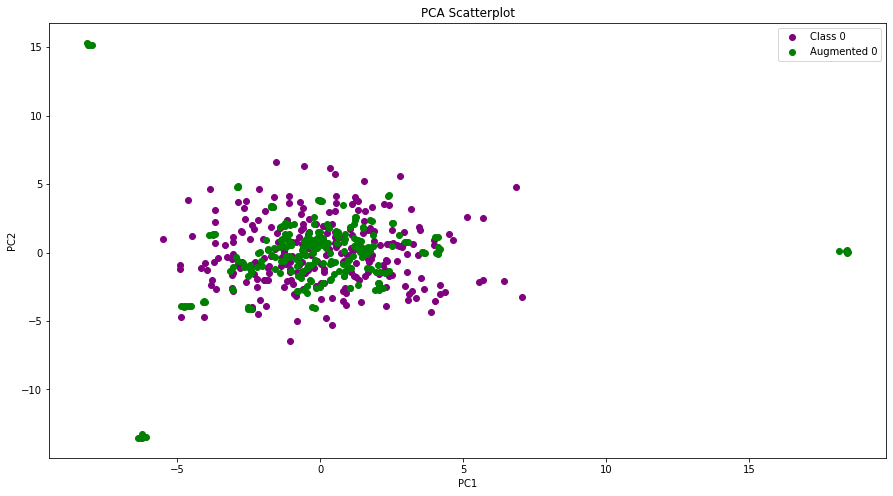

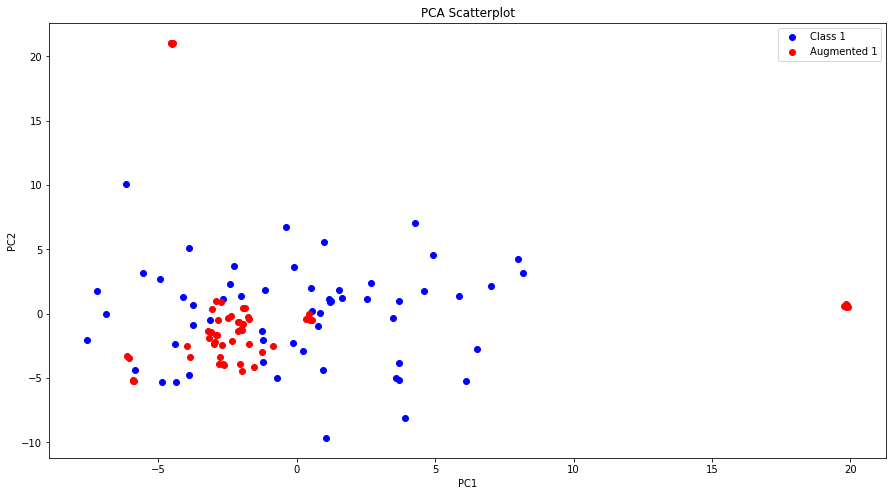

In [ ]:
tuple1 = getPCA(trainLabel0X)
tuple2 = getPCA(trainLabel1X)
tuple3 = getPCA(augmented0)
tuple4 = getPCA(augmented1)

plotPCA([tuple1, tuple3], ['purple', 'green'], ['Class 0', 'Augmented 0'], fileName='Class 0 PCA Transformer.png')
plotPCA([tuple2, tuple4], ['blue', 'red'], ['Class 1', 'Augmented 1'], fileName='Class 1 PCA Transformer.png')

## Create larger datasets through data augmentation

We can see that there are far fewer datasets of class one. That means we need to generate augmented data for that class.

In [ ]:
n = len(trainLabel0X) - len(trainLabel1X)
augmented1 = generateAugmentedDataset(n, 1)

0.00%, 0.49%, 0.97%, 1.46%, 1.94%, 2.43%, 2.91%, 3.40%, 3.88%, 4.37%, 4.85%, 5.34%, 5.83%, 6.31%, 6.80%, 7.28%, 7.77%, 8.25%, 8.74%, 9.22%, 9.71%, 10.19%, 10.68%, 11.17%, 11.65%, 12.14%, 12.62%, 13.11%, 13.59%, 14.08%, 14.56%, 15.05%, 15.53%, 16.02%, 16.50%, 16.99%, 17.48%, 17.96%, 18.45%, 18.93%, 19.42%, 19.90%, 20.39%, 20.87%, 21.36%, 21.84%, 22.33%, 22.82%, 23.30%, 23.79%, 24.27%, 24.76%, 25.24%, 25.73%, 26.21%, 26.70%, 27.18%, 27.67%, 28.16%, 28.64%, 29.13%, 29.61%, 30.10%, 30.58%, 31.07%, 31.55%, 32.04%, 32.52%, 33.01%, 33.50%, 33.98%, 34.47%, 34.95%, 35.44%, 35.92%, 36.41%, 36.89%, 37.38%, 37.86%, 38.35%, 38.83%, 39.32%, 39.81%, 40.29%, 40.78%, 41.26%, 41.75%, 42.23%, 42.72%, 43.20%, 43.69%, 44.17%, 44.66%, 45.15%, 45.63%, 46.12%, 46.60%, 47.09%, 47.57%, 48.06%, 48.54%, 49.03%, 49.51%, 50.00%, 50.49%, 50.97%, 51.46%, 51.94%, 52.43%, 52.91%, 53.40%, 53.88%, 54.37%, 54.85%, 55.34%, 55.83%, 56.31%, 56.80%, 57.28%, 57.77%, 58.25%, 58.74%, 59.22%, 59.71%, 60.19%, 60.68%, 61.17%, 61.65

In [ ]:
# Merge the data together.
combinedDf = trainLabel1X.copy()
augmentedDf = pd.DataFrame(augmented1, columns=combinedDf.columns)
combinedDf = pd.concat([combinedDf, augmentedDf], axis=0)
combinedDf['target'] = 1
combinedDf = pd.concat([combinedDf, trainLabel0], axis=0)

# Separate out X and Y.
combinedDfTrainX = combinedDf.drop(columns=['target'])
combinedDfTrainY = combinedDf['target']

In [ ]:
len(combinedDfTrainX)

528

## Evaluate model accuracy on original data

Now fitting logistic regression
Now fitting k-nearest-neighbors
Now fitting random forest classifier


,Hyperparam,Hyperparam val,CV Accuracy,Test Accuracy
Model,,,,
Logistic Regression,C,0.01,0.816779,0.733813
KNN,n_neighbors,21,0.819904,0.748201
Random Forest,n_estimators,-,-,0.748201


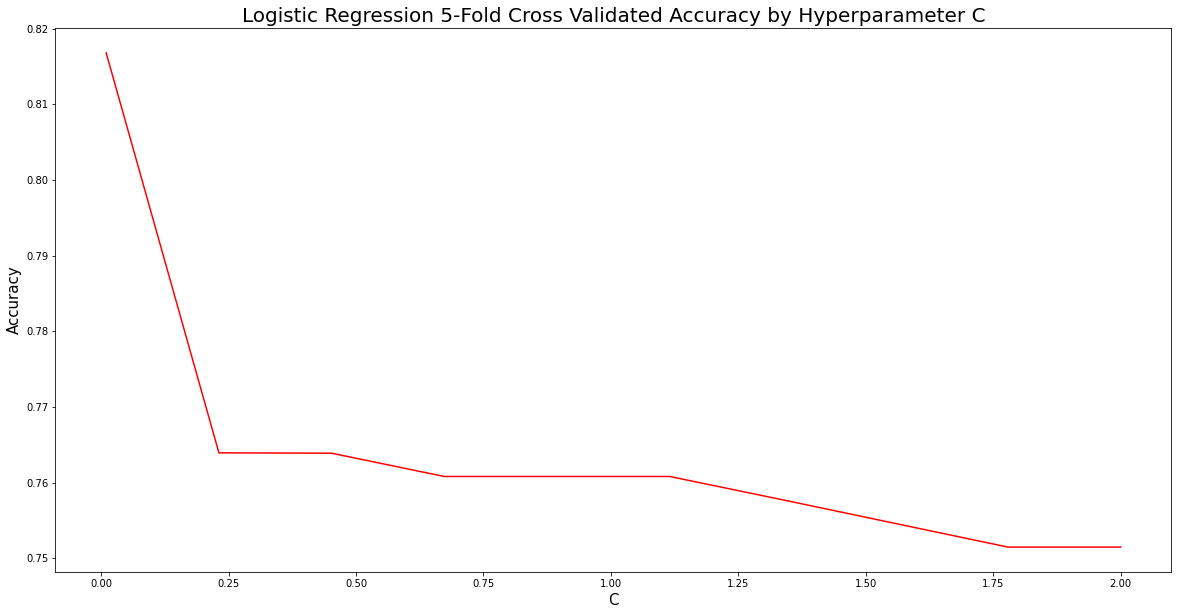

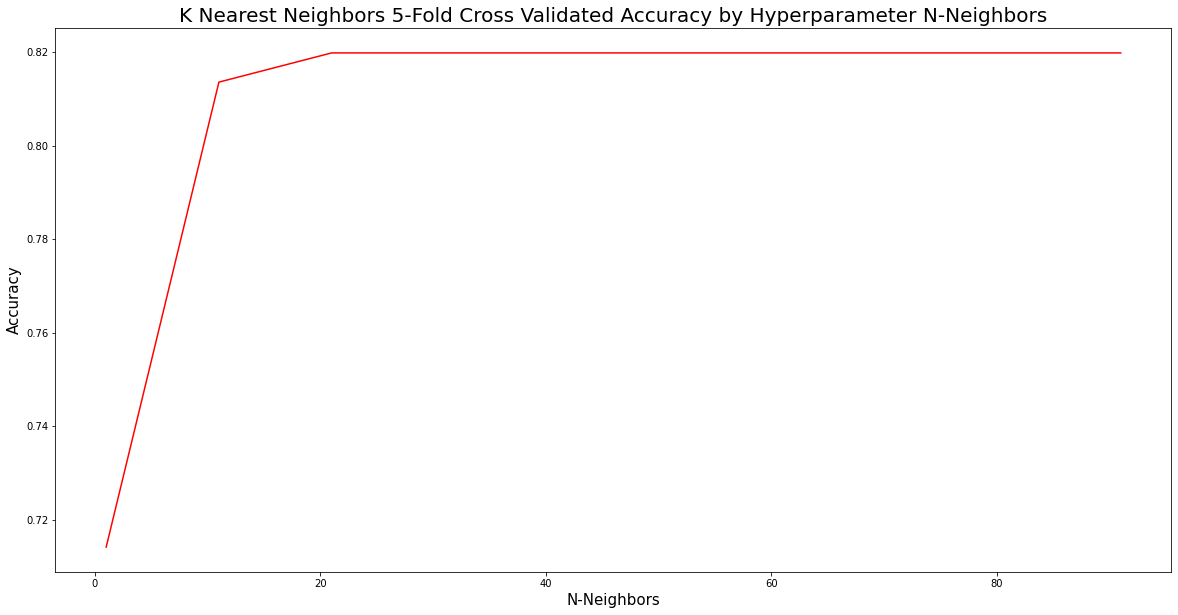

In [ ]:
fitter = automator.AutomaticClassification(trainX, trainY, testX, testY)
reportDf = fitter.main([True, False, True, False, True, False])
reportDf

## Evaluate model accuracy on augmented data

Now fitting logistic regression
Now fitting k-nearest-neighbors
Now fitting random forest classifier


,Hyperparam,Hyperparam val,CV Accuracy,Test Accuracy
Model,,,,
Logistic Regression,C,0.01,0.914789,0.669065
KNN,n_neighbors,1,0.814412,0.582734
Random Forest,n_estimators,-,-,0.776978


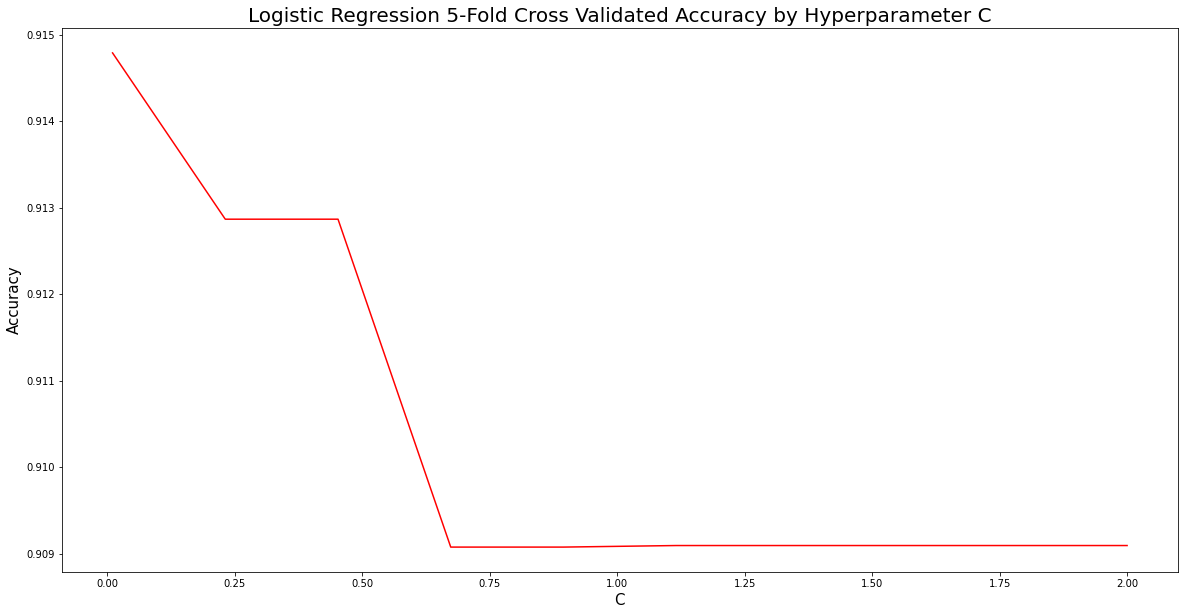

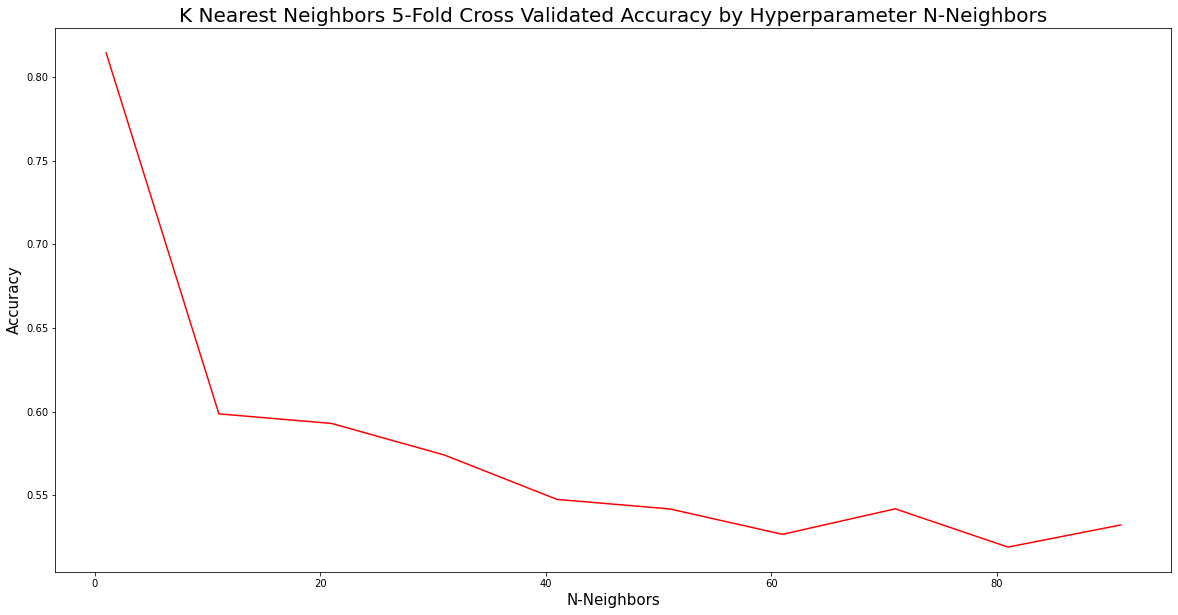

In [ ]:
fitter = automator.AutomaticClassification(combinedDfTrainX, combinedDfTrainY, testX, testY)
reportDf = fitter.main([True, False, True, False, True, False])
reportDf

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(combinedDfTrainX, combinedDfTrainY)
model.score(testX, testY)

0.5323741007194245